# Demonstration of how the Kabsch algorithm works using two simple examples

1) The first is just made up data for 3x50 matrices which demonstrates that the algorithm works how we would expect it to.

2) The second uses coordinate data from protein structures to show how the Kabsch algorithm is applied in computational biology.

Import numpy and necessary packages from Biopython:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBList
from Bio.PDB import PDBParser
import shutil

import warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

 Define plotting function useful for visualising the different stages of the algorithm:

In [2]:
def plot_to_compare(results_1, results_2, label_1, label_2, plot_name):

    '''Generate 3D plots to visualise results and confirm algorithm working as expected

    :param results_1: First matrix
    :type results_1: np.array
    :param results_2: Second matrix to compare to first
    :type results_2: np.array
    :param label_1: Annotation for first matrix
    :type label_1: str
    :param label_2: Annotation for second matrix
    :type label_2: str
    :param plot_name: Title for plot
    :type plot_name: str
    :param file_name: Name for image of plot to be saved as  **REMOVED FOR IPYNB**
    :type file_name: str

    :return: none
    :type: none
    
    '''

    ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    ax.plot(results_1[0], results_1[1], results_1[2], label=label_1, color='r')
    ax.plot(results_2[0], results_2[1], results_2[2], label=label_2, color='b')
    ax.legend(loc='upper left', fontsize=20)
    ax.set_xlabel('X', fontsize=20)
    ax.set_ylabel('Y', fontsize=20)
    ax.set_zlabel('Z', fontsize=20)
    plt.title(plot_name, fontsize=20)
    #plt.savefig(file_name)
    plt.show() # added in for notebook examples
    plt.close()

    return

## Example 1: How does the Kabsch algorithm work?

Generate two matrices, A and B

For the purposes of demonstrating how the algorithm works, A is a visually obvious transformation of B. 

In [3]:
def generate_matrices():

    '''Generates two matrices of X, Y, Z coordinates as an exemplar for algorithm use
    
    :return: Matrix A of size 3x50, with columns X, Y, Z
    :rtype: np.array
    :return: Matrix B of size 3x50, with columns X, Y, Z
    :rtype: np.array
    '''

    # generate x, y, z co-ords and concat into matrix
    theta = np.linspace(10, 20, 50)

    A_z = np.linspace(10, 20, 50)
    r = A_z**2 + 1
    A_x = r * np.sin(theta)
    A_y = r * np.cos(theta)

    B_z = np.linspace(10, 20, 50)
    q = B_z**2 + 1
    B_x = q * np.cos(theta) # switch sin and cos for x and y 
    B_y = q * np.sin(theta)

    # extract points into matrix
    A = np.array([A_x, A_y, A_z], dtype='float32')
    B = np.array([B_x, B_y, B_z], dtype='float32')

    plot_to_compare(results_1=A, results_2=B, label_1='A', label_2='B', plot_name='A vs B')

    return A, B


Plotting A and B shows their similarity and we can also see how A might be mapped onto B, by rotating it.

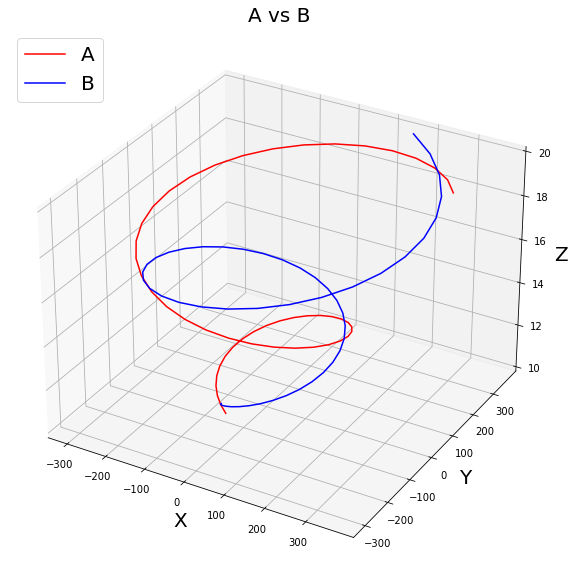

In [4]:
A, B = generate_matrices()

The first step is to translate the coordinates of A and B so that their centroid lies across the origin of the X/Y/Z axes. We do this by finding the mean of each of the columns X, Y and Z, and subtracting the mean value from each value in the column.

In [5]:
def translate_to_origin(matrix):

    ''' Translate a matrix so that its centroid lies on the origin (0,0,0)
    
    :param matrix: Input a matrix of X,Y,Z coordinates
    :type matrix: np.array
    
    :return: Matrix complete with translated coordinates 
    :rtype: np.array
    :return: Means calculated for each of the X,Y,Z columns in matrix
    :rtype: float
    '''
    
    matrix_means = np.mean(matrix, axis=1)
    matrix_translated = matrix.copy()
    for axis in range(len(matrix_means)):
        matrix_translated[axis] -= matrix_means[axis]

    return matrix_translated, matrix_means

Calling this function using A and B as our inputs will translate them. We can see how this works by generating a plot of A vs translated A. 

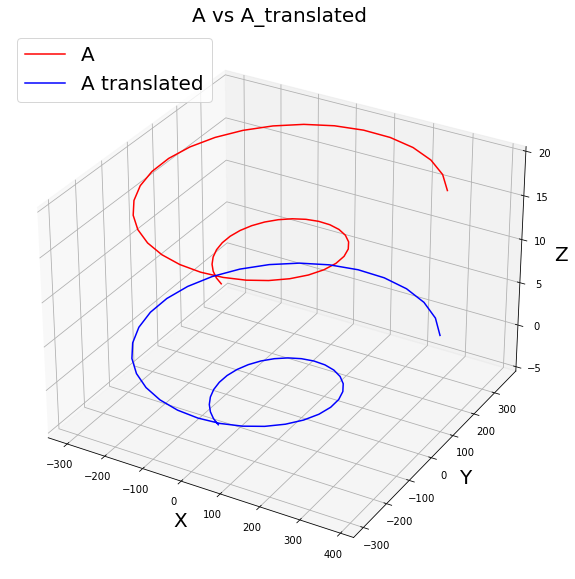

In [6]:
A_translated, A_means = translate_to_origin(A)
B_translated, B_means = translate_to_origin(B)

plot_to_compare(results_1=A, results_2=A_translated, label_1='A', label_2='A translated', plot_name='A vs A_translated')

In [7]:
def compute_covariance_matrix(A_translated, B_translated):

    '''Compute the covariance matrix for 2 input matrices
    
    :param A_translated: Translated matrix A (centroid on origin)
    :type A_translated: np.array
    :param B_translated: Translated matrix B (centroid on origin)
    :type B_translated: np.array 
    
    :return: Covariance matrix
    :rtype: np.array
    '''
    
    # multiply Bt (transposed) by A (gives H)
    H = np.matmul(B_translated.T, A_translated)

    return H

In [10]:
H = compute_covariance_matrix(A_translated, B_translated)

In [11]:
def compute_optimal_rotation_matrix(H):

    '''Compute the optimal rotation matrix from the covariance matrix

    :param H: Covariance matrix
    :type H: np.array
    
    :return: Optimal rotation matrix (R)
    :rtype: np.array
    '''
    
    # find SVD of H 
    U, S, V = np.linalg.svd(H) # np.linalg.svd does not return transpose of V
    Vt = V.T
    # keep matrices 1 and 3 from the decomposition (U and V) - will be Vt if python svd gives transposed V
    # rotation matrix R is Vt x Ut (transposed U) (transpose V if not given as transposed)
    R = np.matmul(Vt, U.T)
    
    return R

In [12]:
R = compute_optimal_rotation_matrix(H)

In [13]:
def apply_rotation(A_translated, R):

    '''Rotate A to align with B using the calculated optimal rotation matrix (R)
    
    :param A_translated: Translated matrix A
    :type A_translated: np.array
    "param R: Optimal rotation matrix
    :type R: np.array
    
    :return: Matrix of rotated X,Y,Z coordinates for A to align with matrix B
    :rtype: np.array
    '''

    # to get rotated A, multiply A x R
    A_rotated = np.matmul(A_translated, R)

    return A_rotated

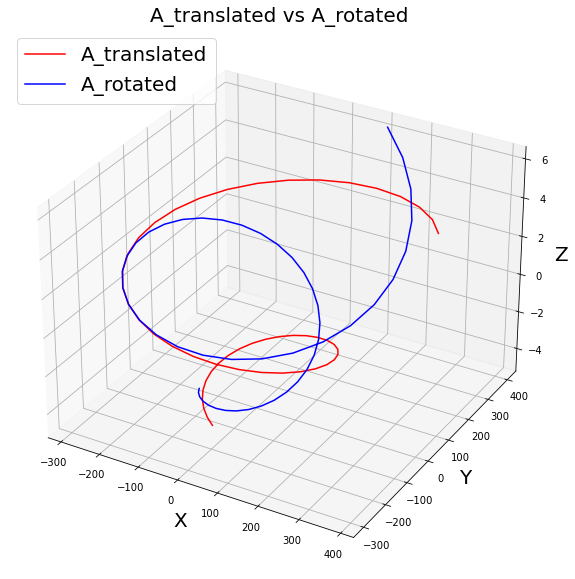

In [14]:
A_rotated = apply_rotation(A_translated, R)
plot_to_compare(results_1=A_translated, results_2=A_rotated, label_1='A_translated', label_2='A_rotated', plot_name='A_translated vs A_rotated')

In [15]:
# 4 translate A back to where B originally was centered (add back averages to matrix columns)
def revert_translation(A_rotated, B_translated, A_means, B_means):

    '''To finalise mapping of A to B, translate both matrices back from origin to original centroid placement

    :param A_rotated: Use translated and rotated matrix of A coordinates
    :type A_rotated: np.array
    :param B_translated: Translated matrix B
    :type B_translated: np.array
    :param A_means: Mean X, Y and Z coordinates for matrix A
    :type A_means: float
    :param B_means: Mean X, Y and Z coordinates for matrix B
    :type B_means: float

    :return: Updated matrix for A, translated back to original centroid placement
    :rtype: np.array
    :return: Updated matrix for B, translated back to original centroid placement (identical to original matrix B)
    :rtype: np.array
    '''
    
    A_reverted = A_rotated.copy()
    for axis in range(len(A_means)):
        A_reverted[axis] += A_means[axis]

    B_reverted = B_translated.copy()
    for axis in range(len(B_means)):
        B_reverted[axis] += B_means[axis]

    return A_reverted, B_reverted

In [16]:
A_reverted, B_reverted = revert_translation(A_rotated, B_translated, A_means, B_means)


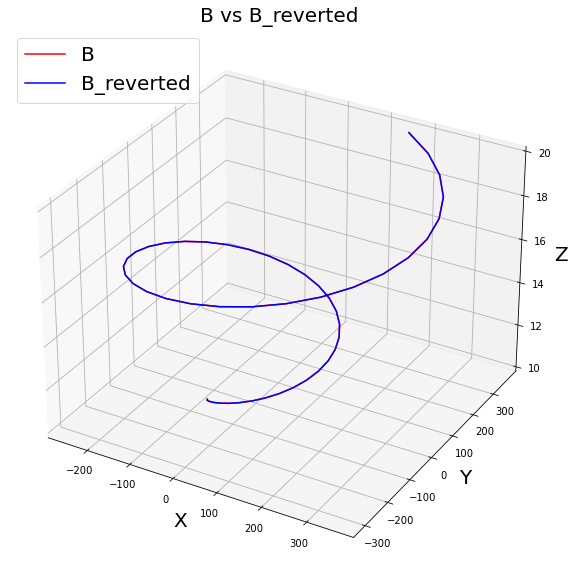

In [17]:
plot_to_compare(results_1=B, results_2=B_reverted, label_1='B', label_2='B_reverted', plot_name='B vs B_reverted')


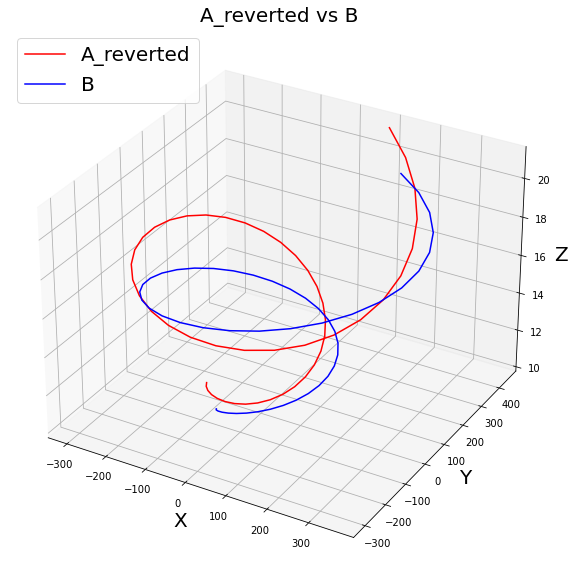

In [18]:
plot_to_compare(results_1=A_reverted, results_2=B, label_1='A_reverted', label_2='B', plot_name='A_reverted vs B')


To run all of the above and just generate our main results we can use the below function:

In [19]:
def run_kabsch_simple_example():

    '''Run the Kabsch algorithm using the example coordinates given in function generate_matrices()
    
    :return: none
    :rtype: none
    '''

    A, B = generate_matrices()  
    A_translated, A_means = translate_to_origin(A)
    B_translated, B_means = translate_to_origin(B)
    H = compute_covariance_matrix(A_translated, B_translated)
    R = compute_optimal_rotation_matrix(H)
    A_rotated = apply_rotation(A_translated, R)
    A_reverted, B_reverted = revert_translation(A_rotated, B_translated, A_means, B_means)

    plot_to_compare(results_1=A, results_2=B, label_1='matrix A pre-Kabsch', 
                    label_2='matrix B pre-Kabsch', plot_name='Matrices A and B before applying Kabsch alignment', 
                    file_name='A vs B pre-Kabsch')
    plot_to_compare(results_1=A_reverted, results_2=B, label_1='matrix A post-Kabsch', 
                    label_2='matrix B', plot_name='Matrix A mapped to B with Kabsch algorithm', 
                    file_name='A vs B post-Kabsch')
    
    return

## Example 2: Using PDB data

This works in the same way as explained in the above steps, but uses 2 protein structures chosen by the user, converts them to 3xN matrices of X,Y,Z coordinates and then applies the alignment algorithm. The function import_matrices() is called in run_kabsch_pdb_example(), where the 2 PDB IDs are specified as arguments.

*Note: The argument 'limit' is given as the algorithm currently only works using two matrices of equal size and shape. As the length of the list of coordinates between 2 protein structures will vary, the maximum limit the user can set is the length of the shorter protein structure (otherwise the function will fail). To be fixed in future!* 

In [23]:
def import_matrices(pdb_id, limit):

    '''Import PDB protein structure co-ordinates and convert to matrix to align two structures

    :param pdb_id: The ID for a protein structure in the PDB database
    :type pdb_id: str, optional
    :param limit: Integer value (500-3000 sensible range for protein coordinates). 
    :type limit: int, optional
    
    :return: Matrix as 2D array of X, Y and Z coordinates for a single protein structure 
    :rtype: np.array
    '''

    pdbl = PDBList()
    pdb_file = pdbl.retrieve_pdb_file(pdb_id, file_format='pdb', overwrite=True, pdir='temp_pdb')

    parser = PDBParser()
    protein_structure = parser.get_structure(str(pdb_id), pdb_file)
    
    x_coords = []
    y_coords = []
    z_coords = []

    for model in protein_structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    x,y,z = atom.get_coord()
                    x_coords.append(x)
                    y_coords.append(y)
                    z_coords.append(z)

    matrix = np.array([x_coords[0:limit], y_coords[0:limit], z_coords[0:limit]])

    shutil.rmtree('temp_pdb')
    # obsolete folder exists depending on PDB structure, ignore error if doesn't exist
    shutil.rmtree('obsolete', ignore_errors=True)

    return matrix

In [26]:
def run_kabsch_pdb_example(pdb_id_1, pdb_id_2, limit=1000):

    '''Run the Kabsch algorithm using function import_matrices() with user input protein structures

    :param pdb_id_1: PDB ID of a protein structure to map to a second
    :type pdb_id_1: str
    :param pdb_id_2: PDB ID of a protein structure to which the first is mapped
    :type pdb_id_2: str
    :param limit: Integer value for a limit to the number of coordinates used in matrix (i.e., the N in the 3xN matrix generated by import_matrices()), default=1000
    :type limit: int

    :return: none
    :rtype: none
    '''

    A = import_matrices(pdb_id=pdb_id_1, limit=limit)  
    B = import_matrices(pdb_id=pdb_id_2, limit=limit)  
    A_translated, A_means = translate_to_origin(A)
    B_translated, B_means = translate_to_origin(B)
    H = compute_covariance_matrix(A_translated, B_translated)
    R = compute_optimal_rotation_matrix(H)
    A_rotated = apply_rotation(A_translated, R)
    A_reverted, B_reverted = revert_translation(A_rotated, B_translated, A_means, B_means)

    # NOTE file_name param removed for IPYNB
    plot_to_compare(results_1=A, results_2=B, label_1=str(pdb_id_1) + ' pre-Kabsch', 
                    label_2=str(pdb_id_2) + ' pre-Kabsch', 
                    plot_name='Proteins ' + pdb_id_1 + ' and ' + pdb_id_2 + ' before applying Kabsch alignment')
    plot_to_compare(results_1=A_reverted, results_2=B, label_1=str(pdb_id_1) + ' post-Kabsch', 
                    label_2=str(pdb_id_2), 
                    plot_name='Protein ' + pdb_id_1 + ' mapped to ' + pdb_id_2 + ' with Kabsch algorithm')
    
    return

Visualising the original positions of 7cr5 and 7co2 examples and comparing to the results after the Kabsch algorithm demonstrates how the 7cr5 structure has been aligned to 7co2, due to similarities in their structures.

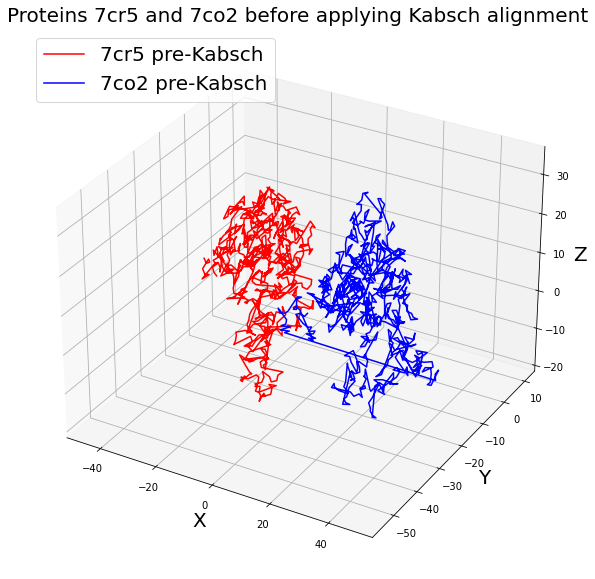

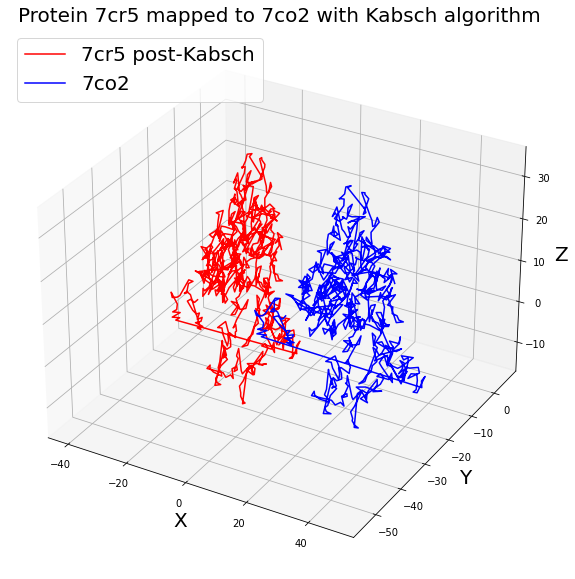

In [27]:
run_kabsch_pdb_example(pdb_id_1='7cr5', pdb_id_2='7co2', limit=800)

### Sources
- https://zpl.fi/aligning-point-patterns-with-kabsch-umeyama-algorithm/
- https://pymolwiki.org/index.php/Kabsch#:~:text=The%20Kabsch%20algorithm%20uses%20linear,implementation%20of%20the%20Kabsch%20algorithm.
- https://stackoverflow.com/questions/60877274/optimal-rotation-in-3d-with-kabsch-algorithm
- https://towardsdatascience.com/the-definitive-procedure-for-aligning-two-sets-of-3d-points-with-the-kabsch-algorithm-a7ec2126c87e
- http://computerandchemistry.blogspot.com/2013/04/calculate-rmsd-from-two-xyz-files.html